<a href="https://colab.research.google.com/github/ehsankarami1358/ImagingSVHN/blob/main/Session08_Workshop3_CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cross-validation: evaluating estimator performance

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally.

In scikit-learn a random split into training and test sets can be quickly computed with the train_test_split helper function. Let’s load the iris data set to fit a linear support vector machine on it:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter("ignore")

In [2]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X.shape, y.shape

((569, 30), (569,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

print('Train Data Shape: ', X_train.shape, y_train.shape)
print('Test Data Shape: ', X_test.shape, y_test.shape)

Train Data Shape:  (398, 30) (398,)
Test Data Shape:  (171, 30) (171,)


In [4]:
clf = LogisticRegression()
clf.fit(X_train, y_train) #classifier

LogisticRegression()

In [5]:
clf.coef_

array([[ 1.02634843,  0.48877845,  0.24392103, -0.01786094, -0.0374449 ,
        -0.18326287, -0.25809013, -0.11108972, -0.05713755, -0.01145205,
         0.03358583,  0.4556479 ,  0.06778265, -0.10661583, -0.00352986,
        -0.03862   , -0.05301644, -0.01415788, -0.01385201, -0.0035829 ,
         1.04572569, -0.54732488, -0.23407074, -0.01169313, -0.06736386,
        -0.55487322, -0.69081761, -0.20476727, -0.18626577, -0.05115938]])

In [6]:
clf.score(X_test, y_test)

0.9707602339181286

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

A model is trained using k-1 of the folds as training data;
the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.

In [7]:
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(solver='lbfgs', max_iter=500)
scores = cross_val_score(clf, X, y, cv=5)
print(scores)

[0.93859649 0.93859649 0.97368421 0.94736842 0.96460177]


In [8]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.95 (+/- 0.01)


In [9]:
# from sklearn import metrics
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
scores

array([0.93220627, 0.93369339, 0.97158288, 0.94345238, 0.96245847])

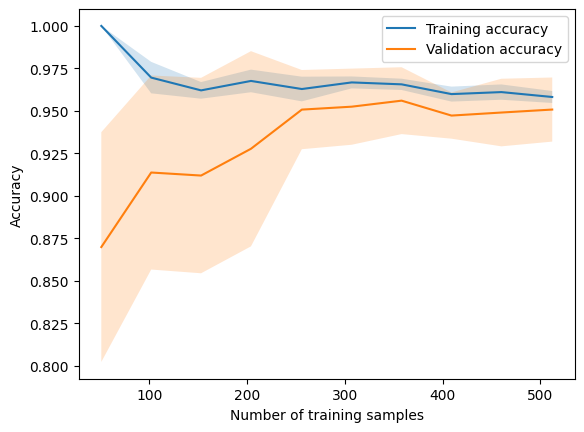

In [10]:
# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=10, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.2)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [11]:
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
cross_val_score(clf, X, y, cv=cv)

array([0.97076023, 0.97076023, 0.97076023])

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

predicted = cross_val_predict(clf, X, y, cv=10)
metrics.accuracy_score(y, predicted)

0.9507908611599297

In [13]:
from sklearn.linear_model import LassoCV

##Cross validation iterators

The following sections list utilities to generate indices that can be used to generate dataset splits according to different cross validation strategies.

Assuming that some data is Independent Identically Distributed (i.i.d.) is making the assumption that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

The following cross-validators can be used in such cases.

In [14]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=True)
X = ["a", "b", "c", "d"]
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 1 2] [3]
[0 2 3] [1]
[0 1 3] [2]


In [15]:
from sklearn.model_selection import StratifiedKFold
X = np.ones(20)
y = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))

[ 2  3  9 10 11 12 13 14 15 16 17 18 19] [0 1 4 5 6 7 8]
[ 0  1  3  4  5  6  7  8 15 16 17 18 19] [ 2  9 10 11 12 13 14]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14] [ 3 15 16 17 18 19]


##Grouped Data

The i.i.d. assumption is broken if the underlying generative process yield groups of dependent samples.

Such a grouping of data is domain specific. An example would be when there is medical data collected from multiple patients, with multiple samples taken from each patient. And such data is likely to be dependent on the individual group. In our example, the patient id for each sample will be its group identifier.

In this case we would like to know if a model trained on a particular set of groups generalizes well to the unseen groups. To measure this, we need to ensure that all the samples in the validation fold come from groups that are not represented at all in the paired training fold.

The following cross-validation splitters can be used to do that. The grouping identifier for the samples is specified via the groups parameter.

In [16]:
from sklearn.model_selection import GroupKFold
X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
y = ["a", "b", "b", "b", "c", "c", "c", "d", "d", "d"]
groups = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3]

gkf = GroupKFold(n_splits=3)
for train, test in gkf.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[0 1 2 3 4 5] [6 7 8 9]
[0 1 2 6 7 8 9] [3 4 5]
[3 4 5 6 7 8 9] [0 1 2]


##Time Series Split

TimeSeriesSplit is a variation of k-fold which returns first k folds as train set and the (k+1) th fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model.

This class can be used to cross-validate time series data samples that are observed at fixed time intervals.

In [17]:
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)

for train, test in tscv.split(X):
    print("%s %s" % (train, test))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]
